In [1]:
import sys
sys.path.append('/Users/Malachite/Documents/UW/ARA/ARA-Plumes/')
from models import PLUME

# Instantiate PLUME object

In [2]:
video_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_high_2/high_2.MP4"
plume_learner = PLUME(video_path=video_path)

plume_leak_source = (1586, 1017)
plume_learner.orig_center = plume_leak_source

seconds = 2

fixed_range = 4*119+34
# img_range = [fixed_range+seconds*plume_learner.fps, plume_learner.tot_frames - plume_learner.fps*13]
img_range = [fixed_range+seconds*plume_learner.fps, 600+fixed_range+seconds*plume_learner.fps]

# Apply Concentric Circles

In [3]:
folder_name = "gauss_time_blur_2"

gauss_space_blur = True
gauss_kernel_size = 251
gauss_space_sigma = 105

gauss_time_blur = True
gauss_time_window = 5
gauss_time_sigma =0.5


mean_smoothing = True
mean_smoothing_sigma = 3

# output = plume_learner.train(img_range=img_range,
#                              fixed_range=fixed_range,
#                              gauss_space_blur=gauss_space_blur,
#                              gauss_kernel_size=gauss_kernel_size,
#                              gauss_space_sigma=gauss_space_sigma,
#                              gauss_time_blur=gauss_time_blur,
#                              gauss_time_window=gauss_time_window,
#                              gauss_time_sigma=gauss_time_sigma,
#                              mean_smoothing=mean_smoothing,
#                              mean_smoothing_sigma=mean_smoothing_sigma)

## Save arrays to pickle file

In [4]:
import pickle

### Save poly coeff

In [5]:
# arrays_dict = {
#     'mean': plume_learner.mean_poly,
#     'var1': plume_learner.var1_poly,
#     'var2': plume_learner.var1_poly
# }

# pickle_name = folder_name+"/gauss_blur_coeff.pkl"

# with open(pickle_name, 'wb') as f:
#     pickle.dump(arrays_dict,f)

### Load poly coeff

In [6]:
pickle_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_high_2/"+folder_name+"/gauss_blur_coeff.pkl"

with open(pickle_path, 'rb') as f:
    loaded_arrays = pickle.load(f)

mean_array = loaded_arrays["mean"]
var1_array = loaded_arrays["var1"]
var2_array = loaded_arrays["var2"]

# Apply an Ensemble SINDy

In [7]:
import pysindy as ps
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [8]:
start_time = 0
end_time = mean_array.shape[0]/plume_learner.fps
t = np.linspace(start_time,end_time,mean_array.shape[0])

### Learn un-normalized ODE system

In [9]:
# SINDy model
feature_names = ['a', 'b','c']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names,
                 optimizer=ensemble_optimizer)
model.fit(mean_array,t=t,ensemble=True,quiet=True)
model.print()

(a)' = 0.000
(b)' = -24.324 1 + 100.115 b + 334.868 a c + -79.766 b^2
(c)' = -10034.870 1 + 148416587.508 a + 58774.856 b + 42.007 c + -169584133.395 a b + -449387.637 a c + -51621.401 b^2 + -156.968 b c


### Solve un-normalized ODE system 

In [10]:
X_train = mean_array
t_train = t
x0 = X_train[0]

# X_train_sim = model.simulate(x0, t_train)

In [11]:
# m = min(X_train.shape[0],X_train_sim.shape[0])

# fig, axs = plt.subplots(X_train.shape[1], 1, sharex=True, figsize=(7, 9))
# for i in range(X_train.shape[1]):
#     axs[i].plot(t_train[:m], X_train[:m, i], "k", label="true simulation")
#     axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--", label="model simulation")
#     axs[i].legend()
#     axs[i].set(xlabel="t", ylabel="Coeff {}".format(feature_names[i]))
# fig.show()

### Learn normalized ODE system

In [12]:
# SINDy model with normalized coeff
scalar = StandardScaler()
normalized_mean_array = scalar.fit_transform(mean_array)

feature_names = ['a','b','c']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names,
                 optimizer=ensemble_optimizer)
model.fit(normalized_mean_array,t=t,ensemble=True,quiet=True)
model.print()

(a)' = -6.097 1 + -190.262 a + -283.794 b + -93.078 c + 544.197 a^2 + 1619.270 a b + 572.035 a c + 1197.221 b^2 + 832.666 b c + 140.115 c^2
(b)' = 5.948 1 + 188.482 a + 279.599 b + 92.058 c + -519.461 a^2 + -1539.611 a b + -539.485 a c + -1132.138 b^2 + -778.353 b c + -128.455 c^2
(c)' = -5.523 1 + -179.371 a + -264.249 b + -87.498 c + 490.889 a^2 + 1445.018 a b + 501.155 a c + 1051.705 b^2 + 710.496 b c + 113.284 c^2


### Solve normalized ODE system
Based on [PySindy Docs](https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#Simulate-forward-in-time).

In [13]:
# More for myself. What is difference between model.simulate and model.predict? 
# The latter is predicting derivatives of learned model
X_train = normalized_mean_array
t_train = t
x0 = X_train[0]

X_train_sim = model.simulate(x0, t_train)



 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402145858052D+01   r2 =  0.1081274673757D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402145858052D+01   r2 =  0.1081274673757D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402145858052D+01   r2 =  0.1081274673757D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402145858052D+01   r2 =  0.1081274673757D-15
 lsoda--  warning..internal t (=r1) 

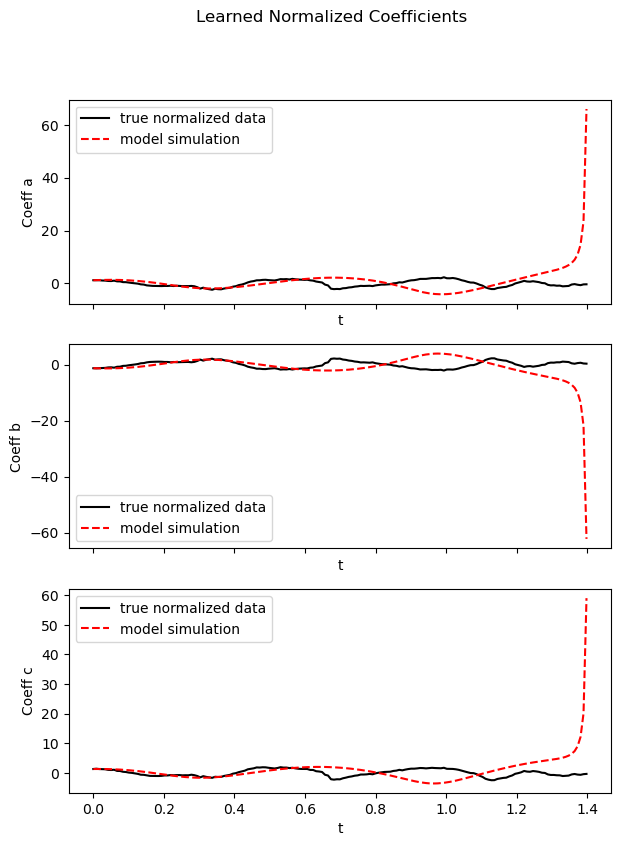

In [44]:
m = min(X_train.shape[0],X_train_sim.shape[0])

fig, axs = plt.subplots(X_train.shape[1], 1, sharex=True, figsize=(7, 9))
fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

for i in range(X_train.shape[1]):
    axs[i].plot(t_train[:m], X_train[:m, i], "k", label="true normalized data")
    axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--", label="model simulation")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel="Coeff {}".format(feature_names[i]))
fig.show()

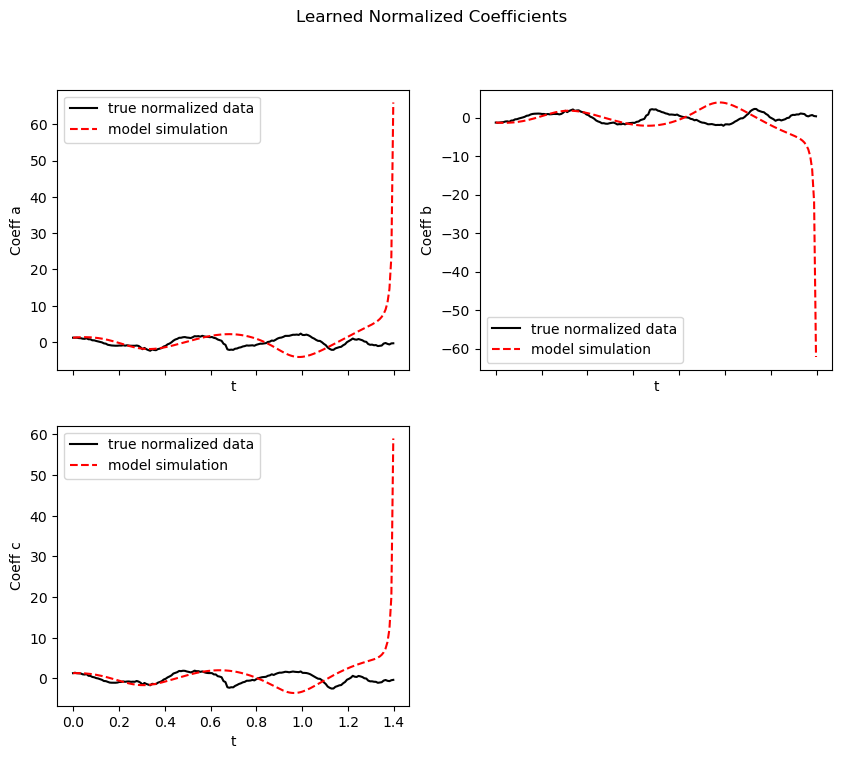

In [50]:
# Assuming you have 3 columns in X_train
nrows = 2
ncols = 2

fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=(10, 8))
fig.suptitle("Learned Normalized Coefficients")

for i in range(nrows):
    for j in range(ncols):
        index = i * ncols + j
        if index < X_train.shape[1]:
            axs[i, j].plot(t_train[:m], X_train[:m, index], "k", label="true normalized data")
            axs[i, j].plot(t_train[:m], X_train_sim[:m, index], "r--", label="model simulation")
            axs[i, j].legend()
            axs[i, j].set(xlabel="t", ylabel="Coeff {}".format(feature_names[index]))
        else:
            # Hide empty subplots
            axs[i, j].axis('off')

plt.show()

In [15]:
X_train

array([[ 1.21768668, -1.27587101,  1.28819045],
       [ 1.22036657, -1.319117  ,  1.38982962],
       [ 1.21876667, -1.26964671,  1.2729086 ],
       ...,
       [-2.99018433,  3.50715226, -3.570812  ],
       [-3.53440427,  4.04965349, -4.0793848 ],
       [-3.41012791,  3.87600746, -3.84520692]])

In [16]:
X_train_sim

array([[ 1.21768668e+00, -1.27587101e+00,  1.28819045e+00],
       [ 1.26262522e+00, -1.30608821e+00,  1.29904433e+00],
       [ 1.30002919e+00, -1.32849563e+00,  1.30215929e+00],
       [ 1.32949100e+00, -1.34277395e+00,  1.29734629e+00],
       [ 1.35061794e+00, -1.34862289e+00,  1.28443704e+00],
       [ 1.36303481e+00, -1.34576369e+00,  1.26328614e+00],
       [ 1.36638674e+00, -1.33394196e+00,  1.23377343e+00],
       [ 1.36034263e+00, -1.31293104e+00,  1.19580688e+00],
       [ 1.34459907e+00, -1.28253570e+00,  1.14932574e+00],
       [ 1.31888487e+00, -1.24259654e+00,  1.09430440e+00],
       [ 1.28296643e+00, -1.19299496e+00,  1.03075665e+00],
       [ 1.23665394e+00, -1.13365902e+00,  9.58740908e-01],
       [ 1.17980874e+00, -1.06457021e+00,  8.78366092e-01],
       [ 1.11235187e+00, -9.85771310e-01,  7.89798671e-01],
       [ 1.03427408e+00, -8.97375465e-01,  6.93270729e-01],
       [ 9.45647346e-01, -7.99576621e-01,  5.89089258e-01],
       [ 8.46637935e-01, -6.92661233e-01

In [22]:
a=X_train_sim[:-3]
b=X_train[:164]

In [30]:
np.linalg.norm(a-b)/np.linalg.norm(b)

2.424147450165934

In [25]:
np.linalg.norm(a)

54.232899806977024

In [34]:
a-b

array([[ 0.00000000e+00, -2.22044605e-16,  0.00000000e+00],
       [ 4.22586456e-02,  1.30287870e-02, -9.07852828e-02],
       [ 8.12625283e-02, -5.88489218e-02,  2.92506937e-02],
       [ 2.19838216e-01, -1.48431919e-01,  5.64466087e-02],
       [ 2.71640038e-01, -1.90848602e-01,  7.91252212e-02],
       [ 4.21650053e-01, -3.48394017e-01,  2.61776852e-01],
       [ 4.63644302e-01, -3.81372345e-01,  2.85663480e-01],
       [ 3.00988806e-01, -2.30135772e-01,  1.51586412e-01],
       [ 5.57322362e-01, -5.26556741e-01,  5.03867635e-01],
       [ 5.46752540e-01, -5.19467760e-01,  4.75215968e-01],
       [ 7.83210869e-01, -7.49339373e-01,  6.77460739e-01],
       [ 7.52313480e-01, -7.37326635e-01,  6.90736454e-01],
       [ 8.63484826e-01, -8.51386759e-01,  8.04313143e-01],
       [ 9.31860537e-01, -8.97946949e-01,  8.12088876e-01],
       [ 9.68401452e-01, -9.54796659e-01,  8.83994009e-01],
       [ 1.02322852e+00, -1.02188273e+00,  9.49992357e-01],
       [ 1.19361586e+00, -1.18600575e+00

In [37]:
X_train

array([[ 1.21768668, -1.27587101,  1.28819045],
       [ 1.22036657, -1.319117  ,  1.38982962],
       [ 1.21876667, -1.26964671,  1.2729086 ],
       ...,
       [-2.99018433,  3.50715226, -3.570812  ],
       [-3.53440427,  4.04965349, -4.0793848 ],
       [-3.41012791,  3.87600746, -3.84520692]])

In [43]:
normalized_mean_array

array([[ 1.21768668, -1.27587101,  1.28819045],
       [ 1.22036657, -1.319117  ,  1.38982962],
       [ 1.21876667, -1.26964671,  1.2729086 ],
       ...,
       [-2.99018433,  3.50715226, -3.570812  ],
       [-3.53440427,  4.04965349, -4.0793848 ],
       [-3.41012791,  3.87600746, -3.84520692]])